# Correlation tests for selected indicators
1. GDP Test

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress, t, combine_pvalues

In [2]:
# Load the data
file_path = "long_formatted_data.csv"

# Load the data from the CSV file
data = pd.read_csv(file_path)
Dependent_variable_code = "SP.DYN.LE00.IN" # Code for Life expectancy

# Get the highest scoring indicators

In [64]:
# Filter dependent and independent variable data
dependent_data = data[data["Indicator Code"] == Dependent_variable_code]
independent_data = data[data["Indicator Code"] != Dependent_variable_code]

# Merge all independent variables with dependent variable data
merged_data = pd.merge(
    dependent_data,
    independent_data,
    on=["Country Code", "Year"],
    suffixes=("_dependent", "_independent")
)

# Ensure that the relevant columns exist
if "Indicator Code_independent" not in merged_data.columns:
    raise KeyError("The 'Indicator Code_independent' column is missing.")

# Drop rows with missing values in dependent and independent values
merged_data = merged_data.dropna(subset=["Value_dependent", "Value_independent"])

# Define a function to compute correlation, R-squared, p-val, and sample size
def compute_stats(group):
    # Extract the dependent and independent values
    x = group["Value_independent"]
    y = group["Value_dependent"]

    # Compute the correlation coefficient, R-squared, and p-value
    corr = np.corrcoef(x, y)[0, 1]
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    r_squared = r_value ** 2

    # Compute the sample size
    n = len(x)

    # Return the computed statistics
    return pd.Series({
        "Correlation Coefficient": corr,
        "R-squared": r_squared,
        "P-value": p_value,
        "N": n
    })

# Group by the correct column name and apply the function
results = merged_data.groupby("Indicator Code_independent").apply(compute_stats).reset_index()
results.rename(columns={"Indicator Code_independent": "Indicator Code"}, inplace=True)

# sort results on descending order of R-squared and correlation coefficient, sample size and ascending order of p-value
results = results.sort_values(
    by=["R-squared", "Correlation Coefficient", "N", "P-value"],
    ascending=[False, False, False, True]
)

# print the top 50 results
# remove any duplicate variants of the same indicator (first three parts (seperated by .) match, e.g. SP.DYN.LE00.IN and SP.DYN.LE00.FE.IN)
# save it in top50_results

# Extract a copy of the relevant column and work on it
results_copy = results.copy()

# Extract the first three parts of the "Indicator Code"
results_copy["Indicator Key"] = results_copy["Indicator Code"].str.extract(r"^([^.]+\.[^.]+\.[^.]+)")

# Remove duplicates based on the extracted "Indicator Key"
unique_results = results_copy.drop_duplicates(subset="Indicator Key")

# Select the top 50 results
top50_results = unique_results[["Indicator Code", "Correlation Coefficient", "R-squared", "N"]].head(50)

# load indicator names and codes
indicator_codes = pd.read_csv("indicator_name_and_code.csv")

# merge indicator names with top50_results
top50_results = pd.merge(top50_results, indicator_codes, on="Indicator Code")

# move the indicator name column to the first
top50_results = top50_results[["Indicator Name", "Indicator Code", "Correlation Coefficient", "R-squared", "N"]]
# Print the top 50 results
print(top50_results)

import seaborn as sns

# Assuming `top20_results` is your DataFrame
# Pivot the data to use Indicator Name for the rows
heatmap_data = top20_results.pivot(index="Indicator Name", values="Correlation Coefficient", columns=None)

# Plot the heatmap
plt.figure(figsize=(12, 8))  # Adjust the figure size
sns.heatmap(
    heatmap_data,
    cmap="RdBu_r",            # Diverging colormap
    annot=True,               # Show R-squared values in each cell
    cbar_kws={'label': 'R-Squared'},  # Add colorbar label
    linewidths=0.5            # Add gridlines for readability
)

# Adjust the plot
plt.ylabel("Indicator Name", fontsize=12)  # Label y-axis
plt.xlabel("")  # No label for x-axis as codes are removed
plt.title("Heatmap of R-Squared Values for Various Indicators", fontsize=14)  # Add title

# Adjust y-axis labels for better readability
plt.yticks(fontsize=10)
plt.tight_layout()  # Automatically adjust layout to prevent overlaps
plt.show()


                                       Indicator Name        Indicator Code  \
0            Life expectancy at birth, female (years)     SP.DYN.LE00.FE.IN   
1            Survival to age 65, female (% of cohort)     SP.DYN.TO65.FE.ZS   
2   Mortality rate, adult, female (per 1,000 femal...        SP.DYN.AMRT.FE   
3   Mortality rate, infant, male (per 1,000 live b...     SP.DYN.IMRT.MA.IN   
4   Mortality rate, under-5, male (per 1,000 live ...        SH.DYN.MORT.MA   
5   Human capital index (HCI), lower bound (scale ...        HD.HCI.OVRL.LB   
6   Cause of death, by non-communicable diseases (...        SH.DTH.NCOM.ZS   
7    Mortality rate, neonatal (per 1,000 live births)           SH.DYN.NMRT   
8   Cause of death, by communicable diseases and m...        SH.DTH.COMM.ZS   
9                          UHC service coverage index     SH.UHC.SRVS.CV.XD   
10  Probability of dying among youth ages 20-24 ye...           SH.DYN.2024   
11  Prevalence of anemia among children (% of chil..

C:\Users\Victor\AppData\Local\Temp\ipykernel_2568\1859849582.py:43: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  results = merged_data.groupby("Indicator Code_independent").apply(compute_stats).reset_index()


KeyError: None

# Select the indicator to test

In [3]:
Independent_variable_code = "NY.GDP.PCAP.CD" # Code for GDP

Independent_variable_name = "GDP per capita"
Independent_variable_short_name = "GDP"
Independent_variable_unit = "USD"

# GDP Test
1. Get the correlation & R^2 value against life expectancy
2. Fit linear regression
3. Get p-val, residuals & confidence interval (95%)
4. Create scatterplot
5. Create plot of residuals

Slope:  0.00024867609348201957
Intercept:  66.85096158940637
R-squared:  0.33411672686696925
R-value:  0.5780283097452661
P-value:  0.0
Standard error:  5.635236647430118e-06
95% Confidence Interval for Slope: (0.000238, 0.000260)


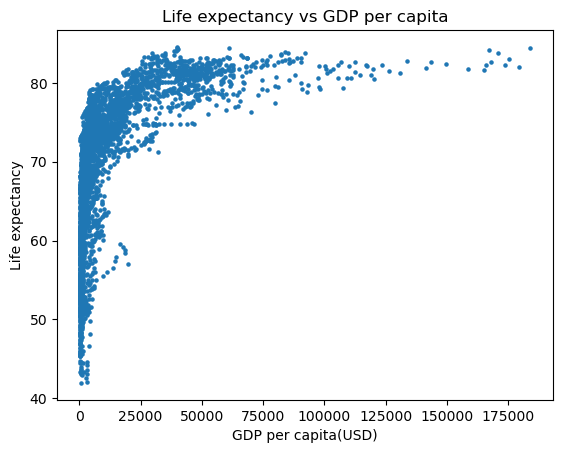

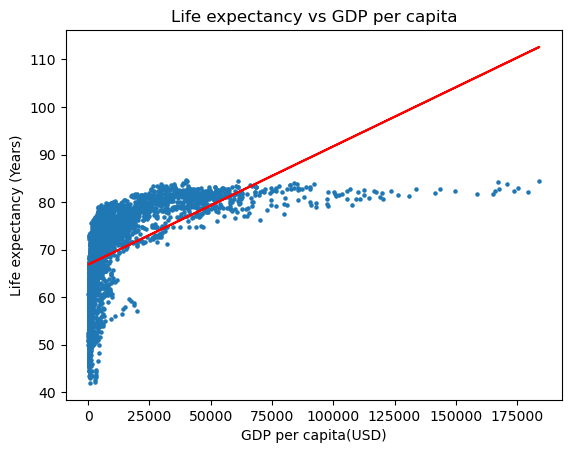

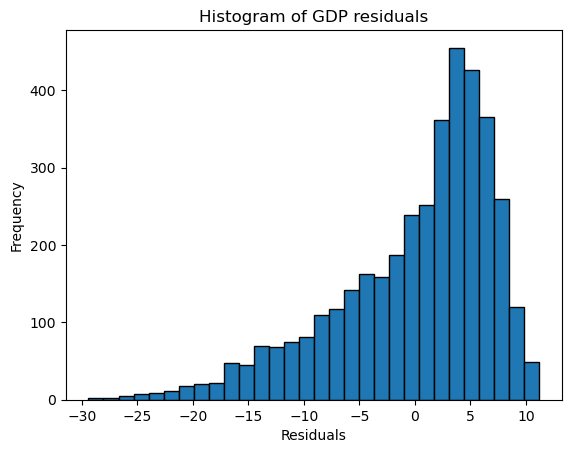

Slope (log):  4.689406802707324
Intercept (log):  30.566989103570506
R-squared (log):  0.6626105960787252
R-value (log):  0.8140089656009479
P-value (log):  0.0
Standard error (log):  0.05371339694801449
95% Confidence Interval for Slope (log): (4.584098, 4.794716)


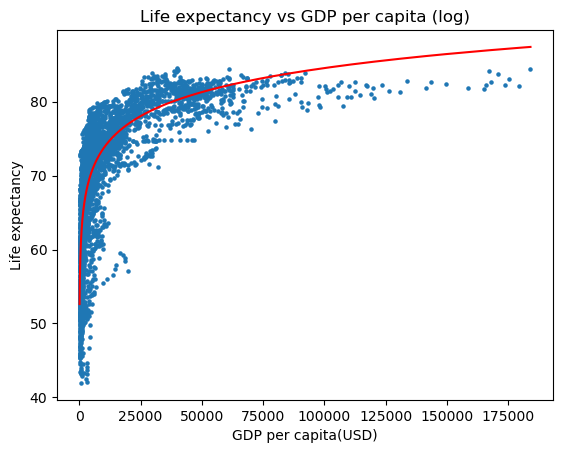

Number of countries:  191


In [21]:

# Get all raw data for the dependent variable
LE_data = data[data["Indicator Code"] == Dependent_variable_code]
# Get all raw data for the independent variable
GDP_data = data[data["Indicator Code"] == Independent_variable_code]

# Join the LE_data and GDP_data on the "Country Code" and "Year" columns
# This makes sure that we have GDP and LE data for the same country and year
GDP_joined_data = pd.merge(GDP_data, LE_data, on=["Country Code", "Year"])

# Drop rows with missing values
# This is necessary because the scatter plot function does not work with missing values
GDP_joined_data = GDP_joined_data.dropna()

# Create array from this data frame in x, y format
# x is GDP per capita
# y is Life expectancy
x = GDP_joined_data["Value_x"]
y = GDP_joined_data["Value_y"]



# Fit Linear Regression and get correlation coefficient, r-squared, p-value, residuals and confidence intervals
slope, intercept, r_value, p_value, std_err = linregress(x, y)

# Calculate the R-squared value
r_squared = r_value**2


# Calculate degrees of freedom
n = len(x)
df = n - 2

# Critical t-value for 95% confidence level
confidence = 0.95
alpha = 1 - confidence
t_critical = t.ppf(1 - alpha / 2, df)

# Margin of error
margin_of_error = t_critical * std_err

# Confidence interval for the slope
slope_ci_lower = slope - margin_of_error
slope_ci_upper = slope + margin_of_error


# Print the results
print("Slope: ", slope)
print("Intercept: ", intercept)
print("R-squared: ", r_squared)
print("R-value: ", r_value)
print("P-value: ", p_value)
print("Standard error: ", std_err)
print("95% Confidence Interval for Slope: ({:.6f}, {:.6f})".format(slope_ci_lower, slope_ci_upper))


# Scatter plot with smaller dot size (s=5)
plt.scatter(x, y, s=5)
plt.xlabel(Independent_variable_name +"(" + Independent_variable_unit + ")")
plt.ylabel("Life expectancy")
plt.title("Life expectancy vs "+Independent_variable_name)
plt.show()


# Scatter plot with linear regression line
plt.scatter(x, y, s=5)
plt.plot(x, slope*x + intercept, color="red")
plt.xlabel(Independent_variable_name +"(" + Independent_variable_unit + ")")
plt.ylabel("Life expectancy (Years)")
plt.title("Life expectancy vs "+Independent_variable_name)
plt.show()

# Plot the residuals in histogram, show some lines between the bars
residuals = y - (slope*x + intercept)
plt.hist(residuals, bins=30, edgecolor="black")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of "+Independent_variable_short_name+" residuals")
plt.show()

# Log transformation of x (GDP per capita)
log_x = np.log(x)

# Fit log-linear regression
slope_log, intercept_log, r_value_log, p_value_log, std_err_log = linregress(log_x, y)

# Calculate R-squared for log regression
r_squared_log = r_value_log**2

# Calculate degrees of freedom
n = len(x)
df_log = n - 2

# Critical t-value for 95% confidence level
confidence = 0.95
alpha = 1 - confidence
t_critical_log = t.ppf(1 - alpha / 2, df_log)

# Margin of error for slope
margin_of_error_log = t_critical_log * std_err_log

# Confidence interval for the slope
slope_ci_lower_log = slope_log - margin_of_error_log
slope_ci_upper_log = slope_log + margin_of_error_log

# Print the regression results
print("Slope (log): ", slope_log)
print("Intercept (log): ", intercept_log)
print("R-squared (log): ", r_squared_log)
print("R-value (log): ", r_value_log)
print("P-value (log): ", p_value_log)
print("Standard error (log): ", std_err_log)
print("95% Confidence Interval for Slope (log): ({:.6f}, {:.6f})".format(slope_ci_lower_log, slope_ci_upper_log))

sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]

# Plot scatter plot and single clean regression line
plt.scatter(x, y, s=5)
plt.plot(x_sorted, slope_log * np.log(x_sorted) + intercept_log, color="red")
plt.xlabel(Independent_variable_name +"(" + Independent_variable_unit + ")")
plt.ylabel("Life expectancy")
plt.title("Life expectancy vs "+Independent_variable_name+" (log)")
plt.show()


print("Number of countries: ",len(np.unique(GDP_data["Country Code"])))

# P-value distribution

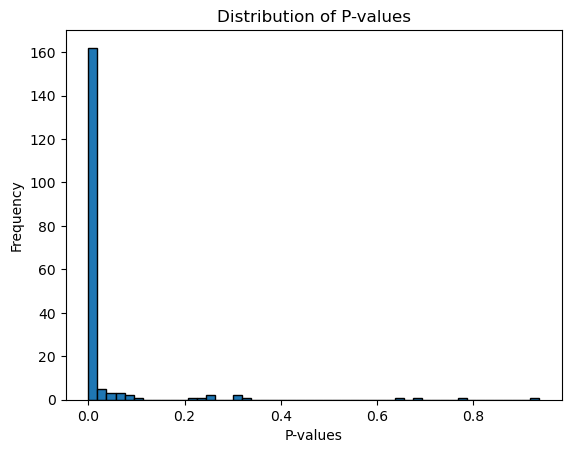

Combined p-value:  0.0


In [23]:
# for each country calculate the p-value
p_values = []
for country in GDP_joined_data["Country Code"].unique():
    country_data = GDP_joined_data[GDP_joined_data["Country Code"] == country]
    
    # Drop rows with NaN values in the relevant columns
    country_data = country_data.dropna(subset=["Value_x", "Value_y"])
    
    x = country_data["Value_x"]
    y = country_data["Value_y"]
    
    # Only proceed if there are at least two points and variation in the data
    if len(x) > 1 and len(np.unique(x)) > 1 and len(np.unique(y)) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(x, y)
        p_values.append(p_value)
    else:
        p_values.append(np.nan)  # Append NaN if regression can't be performed

# # Filter out NaN and invalid p-values
valid_p_values = [p for p in p_values if 0 < p < 1]
plt.hist(valid_p_values, bins=50, edgecolor='black')
plt.xlabel('P-values')
plt.ylabel('Frequency')
plt.title('Distribution of P-values')
plt.show()
# Combine p-values using Fisher's method
combined_p_value = combine_pvalues(valid_p_values, method="fisher")[1]

# Print the combined p-value
print("Combined p-value: ", combined_p_value)